In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pywt
# from scipy.signal import wiener
import skimage as skimg 

# from sklearn.preprocessing import (MinMaxScaler, StandardScaler, FunctionTransformer)
from sklearn.model_selection import (train_test_split,)
# from sklearn.model_selection import (train_test_split, StratifiedKFold, ShuffleSplit)
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import (SVC)

from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (classification_report)

import os
from tqdm import tqdm

In [2]:
class CLASS():
    FAKE = 0
    REAL = 1

### Load image

In [3]:
PATH_PREFIX = '/home/thienn17/Documents/ICL/'
os.path.exists(PATH_PREFIX)

True

In [4]:
class LoadImage():
    def __init__(self, path_prefix):
        assert os.path.exists(path_prefix), "LoadImage, Path does not exist"
        self.path_prefix = path_prefix

        self.cls_folders = [f for f in os.listdir(path_prefix) if f != 'dummy']
        self.cls_id = 0
        self.path_walk = os.walk(os.path.join(path_prefix, self.cls_folders[0]))
        
        self.images = []
        self.labels = []
    
    def reset(self):
        self.images = []
    
    def next_batch(self):
        try:
            while(True):
                abspath, _, files = next(self.path_walk)
                if len(files) > 0: break
            self.reset()
            for file in tqdm(files):
                img = cv2.imread(os.path.join(abspath, file))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    self.images.append(img)
                    self.labels.append(CLASS.REAL if self.cls_folders[self.cls_id][0] == 'S' else CLASS.FAKE)
            return self.images, self.labels
        except StopIteration:
            if self.cls_id == 0:
                self.cls_id += 1
                self.path_walk = os.walk(os.path.join(self.path_prefix, self.cls_folders[self.cls_id]))
                return self.next_batch()

        return None

### Plot wavelet

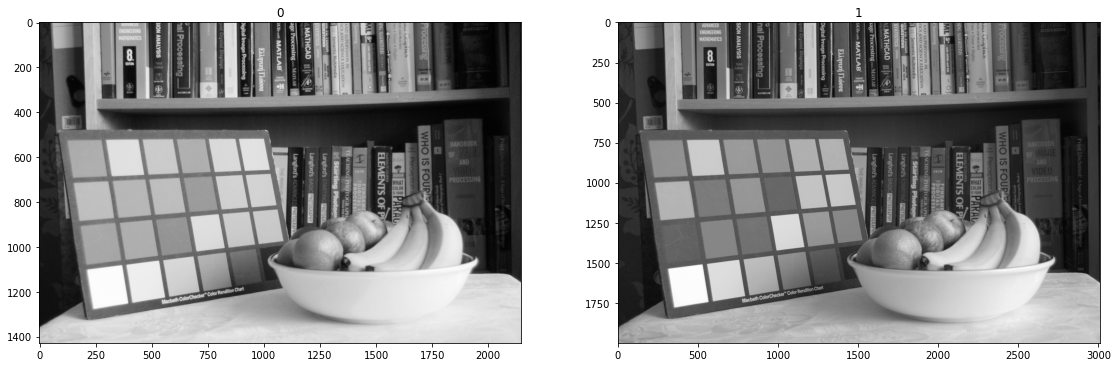

In [78]:
fig, axs = plt.subplots(ncols=2, figsize=(19,6))
for i, img in enumerate(images):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(labels[i])

In [83]:
def img_to_wt_plot(img, wtname = 'haar', level = 2):
    img_wt = pywt.wavedec2(img, wavelet=wtname, level=level)
    apprx = img_wt[0]
    details = img_wt[1:]

    titles = ['H', 'V', 'D']
    fig, axs = plt.subplots(level+1, 3, figsize=(16,9))
    axs[0,0].imshow(apprx, interpolation="nearest", cmap=plt.cm.gray)
    axs[0,1].axis('off')
    axs[0,2].axis('off')

    for rlevel, wt_dec_levels in enumerate(details):
        for j,a in enumerate(wt_dec_levels[:]):
            i = rlevel+1
            axs[i,j].imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            axs[i,j].set_title(titles[j]+' '+str(level-rlevel), fontsize=10)
    fig.suptitle(wtname)
    fig.tight_layout()
    plt.show()

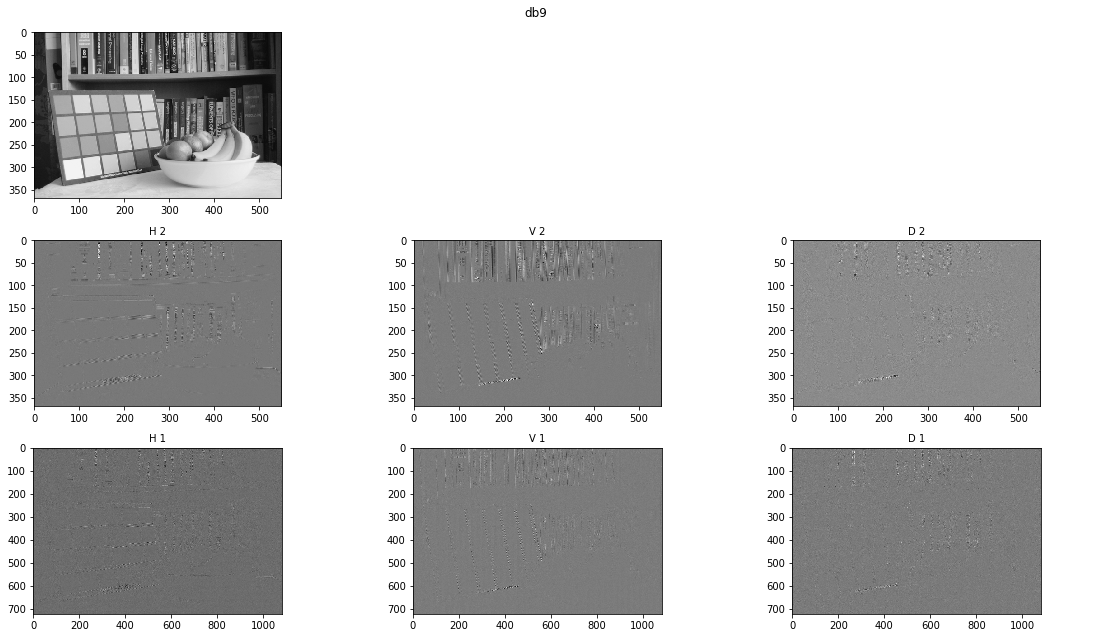

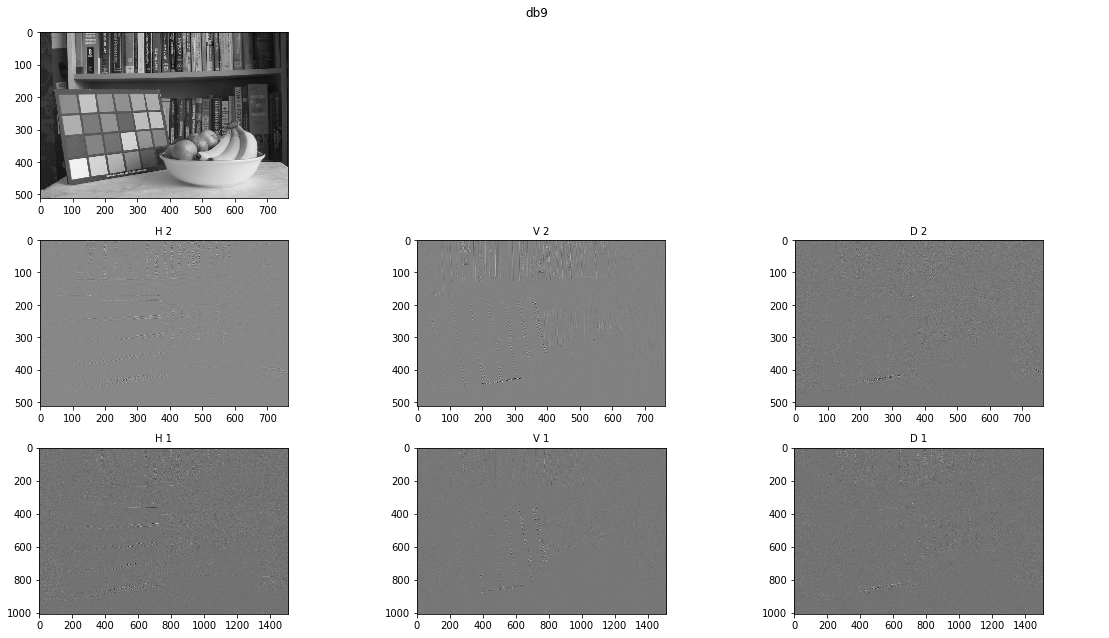

In [84]:
for img in images:
    img_to_wt_plot(img, wtname='db9')

### Feature modules

In [5]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'haar', level = 1):
        '''
        waveletname = ['haar', 'db3', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        features = []
        for img in tqdm(X):
            wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.level)
            details = wt[1:]
            img_features = [wt[0]]
            for levels in details:
                for detail in levels:
                    img_features.append(detail)
            features.append(img_features)
        return features

In [6]:
class NoiseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_points = 8, radius = 1):
        self.num_points = num_points
        self.radius = radius
        # self.ravel = 0

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        features = []
        for img in tqdm(X):
            features.append(self.get_lbp_features(img))
        return features

    def get_lbp_features(self, images):
        def local_binary_pattern(img):
            lbp = skimg.feature.local_binary_pattern(
                img, self.num_points, self.radius, method="nri_uniform").ravel()
            # (hist, bins) = np.histogram(lbp.ravel(), bins=59)
            bins, hist = np.unique(lbp.ravel(), return_counts=True)
            
            hist = hist / len(lbp)
            return hist

        lbp_features = np.zeros(59)
        for img in images:
            lbp_features += local_binary_pattern(img)
        return lbp_features / len(images)

In [7]:
class LbpOnWaveletTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.wtname = 'haar'
        self.wtlevel = 3
        self.num_points = 8
        self.radius = 1
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        features = []
        for img in tqdm(X):
            features.append(self.get_lbp_features(self.get_wt_images(img)))
        return features

    def get_wt_images(self, img):
        wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.wtlevel)
        details = wt[1:]
        wt_img = [wt[0]]
        for levels in details:
            for detail in levels:
                wt_img.append(detail)
        return wt_img
    
    def get_lbp_features(self, images):
        def local_binary_pattern(img):
            lbp = skimg.feature.local_binary_pattern(
                img, self.num_points, self.radius, method="nri_uniform").ravel()
            # (hist, bins) = np.histogram(lbp.ravel(), bins=59)
            bins, hist = np.unique(lbp, return_counts=True)
            
            hist = hist / len(lbp)
            return hist

        lbp_features = np.zeros(59)
        for img in images:
            lbp_features += local_binary_pattern(img)
        return lbp_features / len(images)

### Extract & dump and load

#### Extract & dump

In [8]:
# extractor = make_pipeline(WaveletTransformer(), NoiseTransformer())
extractor = LbpOnWaveletTransformer()
A = np.empty((1,59))
b = None
loader = LoadImage(PATH_PREFIX)
batch = 1
while(True):
    print("Batch {}".format(batch))
    batch += 1
    res = loader.next_batch()
    if res is None:
        break
    images, b = res
    A = np.concatenate((A, extractor.transform(images)), axis=0)

Batch 1


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Batch 2


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Batch 3


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Batch 4


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Batch 5


100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Batch 6


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Batch 7


100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


Batch 8


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


Batch 9


100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


Batch 10


100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Batch 11


100%|██████████| 180/180 [01:44<00:00,  1.72it/s]


Batch 12


100%|██████████| 180/180 [01:20<00:00,  2.25it/s]


Batch 13


100%|██████████| 180/180 [01:31<00:00,  1.97it/s]


Batch 14


100%|██████████| 180/180 [01:32<00:00,  1.94it/s]


Batch 15


100%|██████████| 180/180 [01:31<00:00,  1.96it/s]


Batch 16


100%|██████████| 180/180 [01:20<00:00,  2.22it/s]


Batch 17


100%|██████████| 180/180 [01:33<00:00,  1.92it/s]


Batch 18


100%|██████████| 180/180 [01:41<00:00,  1.77it/s]

Batch 19


In [9]:
A = A[1:]
A.shape

(2345, 59)

In [10]:
PATH_DUMP = "./object dump/no union"
os.path.exists(PATH_DUMP)

True

In [11]:
np.save(os.path.join(PATH_DUMP, "wt-noise_avg.npy"), A)
np.save(os.path.join(PATH_DUMP, "wt-noise_avg_label.npy"), b)

#### Load

In [44]:
PATH_DUMP = "./object dump/no union"
os.path.exists(PATH_DUMP)

True

In [45]:
A = np.load(os.path.join(PATH_DUMP, "wt-noise.npy"))

In [47]:
b = np.load(os.path.join(PATH_DUMP, 'wt-noise_label.npy'))

### Train

In [56]:
# class PercentageNormalizer(BaseEstimator, TransformerMixin):
#     def __init__(self, drop:tuple = ()):
#         self.drop = drop

#     def fit(self, X, y):
#         return self
    
#     def transform(self, X):
#         T = []
#         for img in tqdm(X):
#             T.append(self.percentage_normalize(img))
#         return np.array(T)

#     def percentage_normalize(self, X):
#         X_normalized = []
#         for i,x in enumerate(X):
#             if i in self.drop:
#                 continue
#             x = x / np.sum(x)
#             X_normalized = np.concatenate((X_normalized, x))
#         return np.array(X_normalized)
        

In [10]:
A_train, A_test, b_train, b_test = train_test_split(A, b,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=b)

In [11]:
pipe = SVC().fit(A_train, b_train)

In [12]:
b_pred = pipe.predict(A_test)
print(classification_report(b_test, b_pred))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80       288
           1       0.82      0.30      0.44       181

    accuracy                           0.71       469
   macro avg       0.75      0.63      0.62       469
weighted avg       0.74      0.71      0.66       469



### Visualize

In [57]:
import umap
import seaborn as sns

In [58]:
sns_cmap = sns.color_palette()
color_mapper = {
    0 : sns_cmap[0],  # fake
    1 : sns_cmap[1],  # real
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [59]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    random_state=42)

In [60]:
Af = PercentageNormalizer().transform(A)

100%|██████████| 2345/2345 [00:00<00:00, 15168.40it/s]


In [62]:
embedding = reducer.fit_transform(Af)
embedding.shape

(2345, 2)

Text(0.5, 1.0, 'Umap 50')

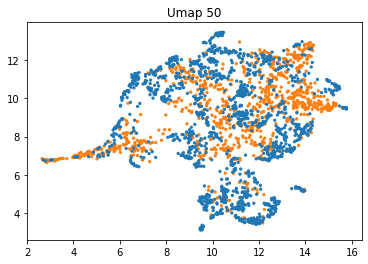

In [63]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for i, a in enumerate(b)],
    s=5)
ax.set_title('Umap {}'.format(reducer.n_neighbors))